## Machine Learning 프로젝트 수행을 위한 코드 구조화

`(분류, 회귀 Task)`

- ML project를 위해서 사용하는 템플릿 코드를 만듭니다.

1. **필요한 라이브러리와 데이터를 불러옵니다.**


2. **EDA를 수행합니다.** 이 때 EDA의 목적은 풀어야하는 문제를 위해서 수행됩니다.


3. **전처리를 수행합니다.** 이 때 중요한건 **feature engineering**을 어떻게 하느냐 입니다.


4. **데이터 분할을 합니다.** 이 때 train data와 test data 간의 분포 차이가 없는지 확인합니다.


5. **학습을 진행합니다.** 어떤 모델을 사용하여 학습할지 정합니다. 성능이 잘 나오는 GBM을 추천합니다.


6. **hyper-parameter tuning을 수행합니다.** 원하는 목표 성능이 나올 때 까지 진행합니다. 검증 단계를 통해 지속적으로 **overfitting이 되지 않게 주의**하세요.


7. **최종 테스트를 진행합니다.** 데이터 분석 대회 포맷에 맞는 submission 파일을 만들어서 성능을 확인해보세요.

## 1. 라이브러리, 데이터 불러오기

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# 데이터분석 4종 세트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 모델들, 성능 평가
# (저는 일반적으로 정형데이터로 머신러닝 분석할 때는 이 2개 모델은 그냥 돌려봅니다. 특히 RF가 테스트하기 좋습니다.)
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from lightgbm.sklearn import LGBMClassifier
from lightgbm.sklearn import LGBMRegressor

# 상관관계 분석, VIF : 다중공선성 제거
from statsmodels.stats.outliers_influence import variance_inflation_factor

# KFold(CV), partial : optuna를 사용하기 위함
from sklearn.model_selection import KFold
from functools import partial

# hyper-parameter tuning을 위한 라이브러리, optuna
#!pip install --quiet optuna
#import optuna

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# data를 불러와 봅니다.
#base_path = '폴더 경로복사하고, 끝에 / 붙이기'
base_path = '/content/drive/MyDrive/pubg-finish-placement-prediction/'

train = pd.read_csv(base_path + "train_V2.csv")
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int64  
 4   boosts           int64  
 5   damageDealt      float64
 6   DBNOs            int64  
 7   headshotKills    int64  
 8   heals            int64  
 9   killPlace        int64  
 10  killPoints       int64  
 11  kills            int64  
 12  killStreaks      int64  
 13  longestKill      float64
 14  matchDuration    int64  
 15  matchType        object 
 16  maxPlace         int64  
 17  numGroups        int64  
 18  rankPoints       int64  
 19  revives          int64  
 20  rideDistance     float64
 21  roadKills        int64  
 22  swimDistance     float64
 23  teamKills        int64  
 24  vehicleDestroys  int64  
 25  walkDistance     float64
 26  weaponsAcquired  int64  
 27  winPoints   

In [ ]:
pd.set_option('display.max_columns', None)
train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,1241,0,0,0.00,1306,squad-fpp,28,26,-1,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,0,0,0,0.00,1777,squad-fpp,26,25,1484,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,0,0,0,0.00,1318,duo,50,47,1491,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,0,0,0,0.00,1436,squad-fpp,31,30,1408,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,0,1,1,58.53,1424,solo-fpp,97,95,1560,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [ ]:
m_types = train.loc[:,"matchType"].value_counts().to_frame().reset_index()
m_types.columns = ["Type","Count"]
m_types

,Type,Count
0,squad-fpp,1756186
1,duo-fpp,996691
2,squad,626526
3,solo-fpp,536762
4,duo,313591
5,solo,181943
6,normal-squad-fpp,17174
7,crashfpp,6287
8,normal-duo-fpp,5489
9,flaretpp,2505


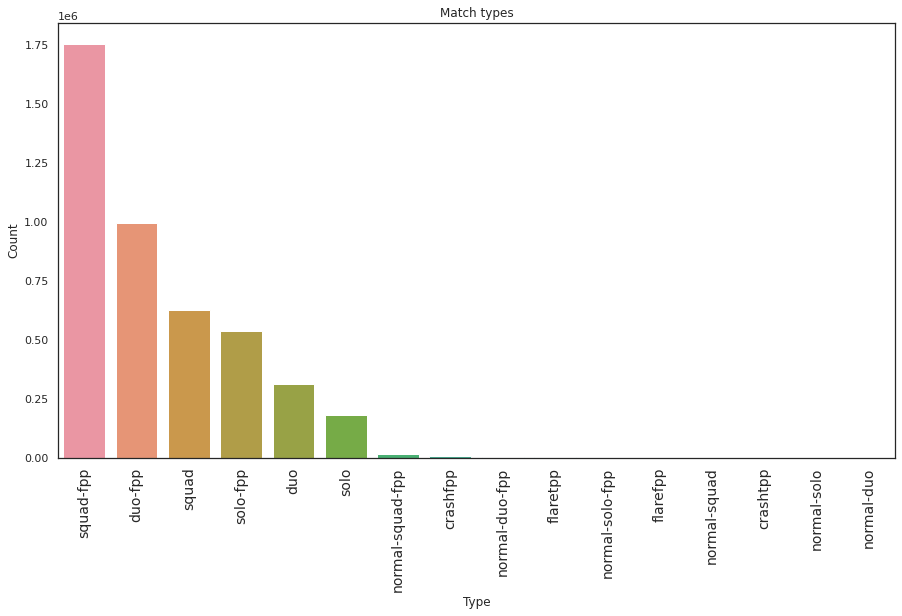

In [ ]:
# squad-fpp의 매치수가 가장 많다.
plt.figure(figsize=(15,8))
ticks = m_types.Type.values
ax = sns.barplot(x="Type", y="Count", data=m_types)
ax.set_xticklabels(ticks, rotation=90, fontsize=14)
ax.set_title("Match types")
plt.show()

In [ ]:
# 각각 타입별 매치 수
# squad 매치수가 많다
m_types2 = train.loc[:,"matchType"].value_counts().to_frame()
aggregated_squads = m_types2.loc[["squad-fpp","squad","normal-squad-fpp","normal-squad"],"matchType"].sum()
aggregated_duos = m_types2.loc[["duo-fpp","duo","normal-duo-fpp","normal-duo"],"matchType"].sum()
aggregated_solo = m_types2.loc[["solo-fpp","solo","normal-solo-fpp","normal-solo"],"matchType"].sum()
aggregated_mt = pd.DataFrame([aggregated_squads,aggregated_duos,aggregated_solo], index=["squad","duo","solo"], columns =["count"])
aggregated_mt

,count
squad,2400402
duo,1315970
solo,720713


In [3]:
# 모집단 train2 (squad-fpp	1756186/4446966)
# tpp과 fpp, 그리고 solo - squad, duo는 시야각과 팀원 역할에 따라 운영방식이 달라지기 때문에, 분석에 사용되는 feature가 달라짐
# 시야각을 이용해 엄폐물을 끼고 운영하는 플레이가 많은 tpp보다 fpp가 승률 예측에 적합하다고 판단 -> 모집단 squad-fpp
# df.drop(df[df.score < 50].index, inplace=True)

train2 = pd.DataFrame()

sqd = train.drop(train[train.matchType != 'squad-fpp'].index)
sqd.shape

train3 = pd.concat([train2, sqd])
train3.shape

(1756186, 29)

In [8]:
4446966-1756186

2690780

In [13]:
# train3.info()
train3.isna().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       0
dtype: int64

In [ ]:
# categorical feature분석
# matchId 18576번의 매치 -> matchId 개수가 적으면 참여 인원이 적은것 -> 분석에 왜곡을 줄 수 있으므로 일정 그룹 수 미만이면 제외할것. 최소 4그룹 이상부터 포함?(기준)
train3.describe(include="O")

,Id,groupId,matchId,matchType
count,1756186,1756186,1756186,1756186
unique,1756186,506161,18576,1
top,7f96b2f878858a,a3bc33847d2304,5b56248ecd9474,squad-fpp
freq,1,31,100,1756186


In [4]:
# 최소 4그룹 이상인 데이터만 남기기

train3[train3.numGroups < 4] # -> 2개의 매치

# 1쿼드 일수도 있으니까 최소 10명 이상
# 거르고 싶은데 아케하지
train3[(train3.numGroups > 3) & (train3.matchId.value_counts > 9)]


TypeError: ignored

In [ ]:
# groupId 2개, 2(win):3, $5명 전원 maxPlace == 2, numGroups == 2$

train3.loc[train3.matchId == '8aa5066c4b6a79'] # groupId == maxPlace == numGroups
train3[train3.matchId == '8aa5066c4b6a79']['winPlacePerc']

696000     0.0
882193     1.0
3620228    0.0
3858347    0.0
3956552    1.0
Name: winPlacePerc, dtype: float64

In [ ]:
# groupId 2개, 4(win):3, $7명 전원 maxPlace == 2, numGroups == 2$

train3.loc[train3.matchId == 'f491e7a7e2ff47'] 
train3.loc[train3.matchId == 'f491e7a7e2ff47']['numGroups']

#결론: groupId.nunique() == maxPlace == numGroups


173764     2
277584     2
577820     2
1177678    2
1262044    2
3497050    2
3588132    2
Name: numGroups, dtype: int64

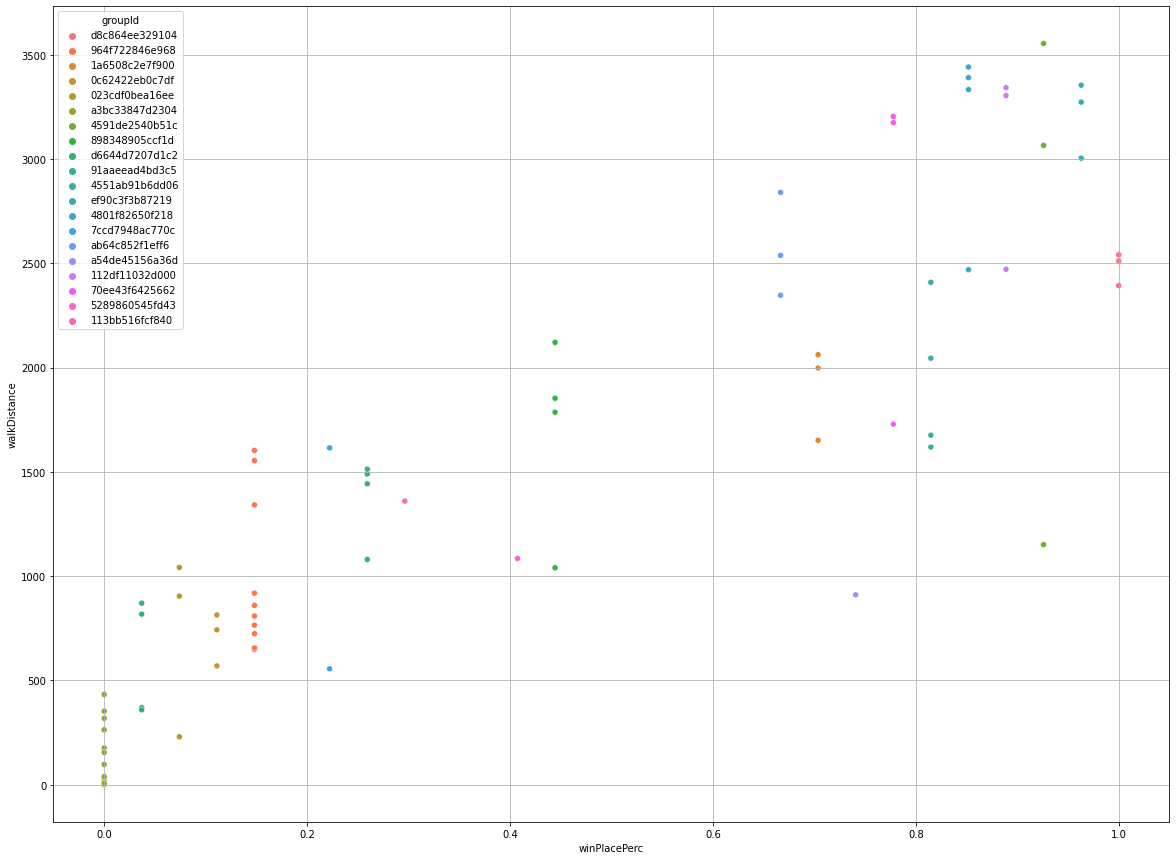

In [14]:
# a3bc33847d2304 팀원 수가 31? -> 일정치 이상은 제거

train3[train3.groupId =='a3bc33847d2304']
a = train3[train3.matchId =='701c7251415d15']

plt.figure(figsize=(20,15))
plt.grid()
# plt.legend(handles, labels)
sns.scatterplot(x='winPlacePerc', y= 'walkDistance', hue='groupId', data=a)


In [ ]:
# 스쿼드 팀별 인원수 (1명~31명)
# 스쿼드 매치별 그룹 수 (2그룹~37그룹)
train3.numGroups.value_counts().sort_index(ascending=False) # 그룹수
train3.groupId.value_counts().sort_values(ascending=False) #팀원 수
train3.matchId.value_counts().sort_values(ascending=False) #게임 참가 인원 수


# train3[train3.numGroups == 37] # e86d83b0902046
# a = train3[train3.matchId == 'e86d83b0902046']
# a.groupId.value_counts() #팀원 수
# a.groupId.nunique() #그룹 수 #37


5b56248ecd9474    100
dedd9bdc503d3d    100
efc2b20c73ae65    100
7a16014fbd913d    100
9d56206a14d984    100
                 ... 
59e4b25fd8d662     17
df73e7ea18f7d8     10
cc75c61415ce85      9
f491e7a7e2ff47      7
8aa5066c4b6a79      5
Name: matchId, Length: 18576, dtype: int64

In [5]:
# 1쿼드 vs 다인쿼드 승률 비교하는것도 괜찮을듯
# x축 winPlacePerc y축 그룹인원수
train3.winPlacePerc.value_counts() #여기에 hue=groupId # x축 index,  

0.0000    103707
1.0000     65418
0.5000     27202
0.3333     21108
0.0370     21055
           ...  
0.7429         2
0.1944         1
0.3611         1
0.8056         1
0.5278         1
Name: winPlacePerc, Length: 397, dtype: int64

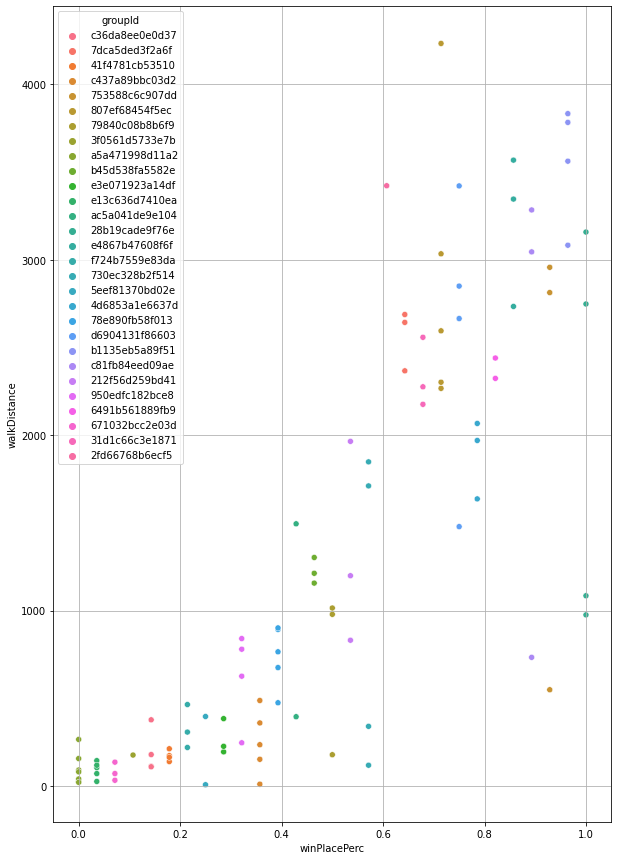

In [18]:
# groupID가 같으면 winPlacePerc도 같다. 같은 그룹은 같은 x좌표에 찍힘. hue= groupId/winPlacePerc

a = train3[train3.matchId =='5b56248ecd9474']

plt.figure(figsize=(10,15))
plt.subplot(121)
plt.grid()
sns.scatterplot(x='winPlacePerc', y= 'walkDistance', hue='groupId', data=a)

plt.subplot(122)
plt.grid()
n = a.groupId.value_counts().sort_values(ascending=False)
sns.barplot(x='winPlacePerc', y= 'walkDistance', hue='groupId', data=a)

# 같은 그룹인데 이동거리 차이가 큰 그룹이 있다.
# 인원 수별로 승률을 확인하고나서 같이 보는게 좋을듯
# 전체 데이터에 대해서도 시각화 할 수 있나?

In [30]:
# legend 순서 바꾸기
n = a.groupId.value_counts().sort_values(ascending=False)
n

a.groupby(['GroupId']).counts().sort_values(ascending=False)


KeyError: ignored

In [42]:
train3[train3.matchId == '863eda30cf6f26']

train3[train3.groupId == 'ef021b9495ad01']['killPlace']


164325      9
1591340    17
1738586    10
2717105    55
3228184    11
Name: killPlace, dtype: int64

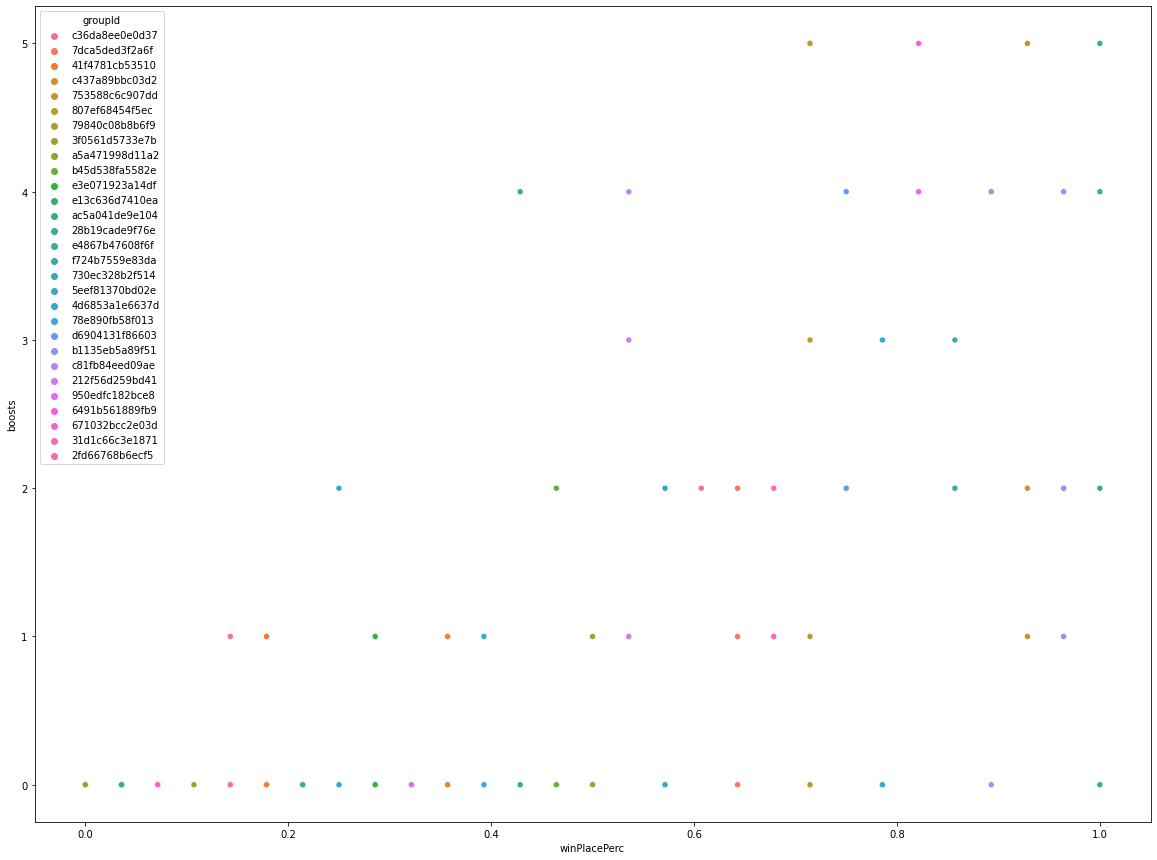

In [7]:
# 부스터 사용 횟수와 승률
plt.figure(figsize=(20,15))
sns.scatterplot(x='winPlacePerc', y= 'boosts', hue='groupId', data=a)

In [46]:
# 킬순위와 승률
k = train3[train3.matchId == '863eda30cf6f26']

plt.figure(figsize=(20,15))
sns.scatterplot(x='winPlacePerc', y= 'killPlace', data=k)

ValueError: ignored

<Figure size 1440x1080 with 0 Axes>

In [ ]:
# 전체 squad-fpp 시각화 -> 안됨

plt.figure(figsize=(20,15))
sns.scatterplot(x='winPlacePerc', y= 'walkDistance', hue='groupId', data=train3)

In [ ]:
#양의 상관관계 지표들 승률 x축으로 두고 Facetgrid 그려보기
# walkDistance 0.824479, boosts   0.634155, weaponsAcquired 0.600584, heals 0.436548, damageDealt 0.427035, longestKill 0.409168, kills 0.401384, killStreaks 0.350781, assists 0.341578

In [ ]:
# flag setting
data_reducing = False ## memory reducing technique
feature_reducing = False ## feature extraction (curse of dimensionality)

In [ ]:
# 데이터를 불러옵니다.
train =
test = 

In [33]:
train3.walkDistance.sort_values(ascending=True)
train3.walkDistance.nunique()


34544

## 2. EDA

- 데이터에서 찾아야 하는 기초적인 내용들을 확인합니다.


- class imbalance, target distribution, outlier, correlation을 확인합니다.

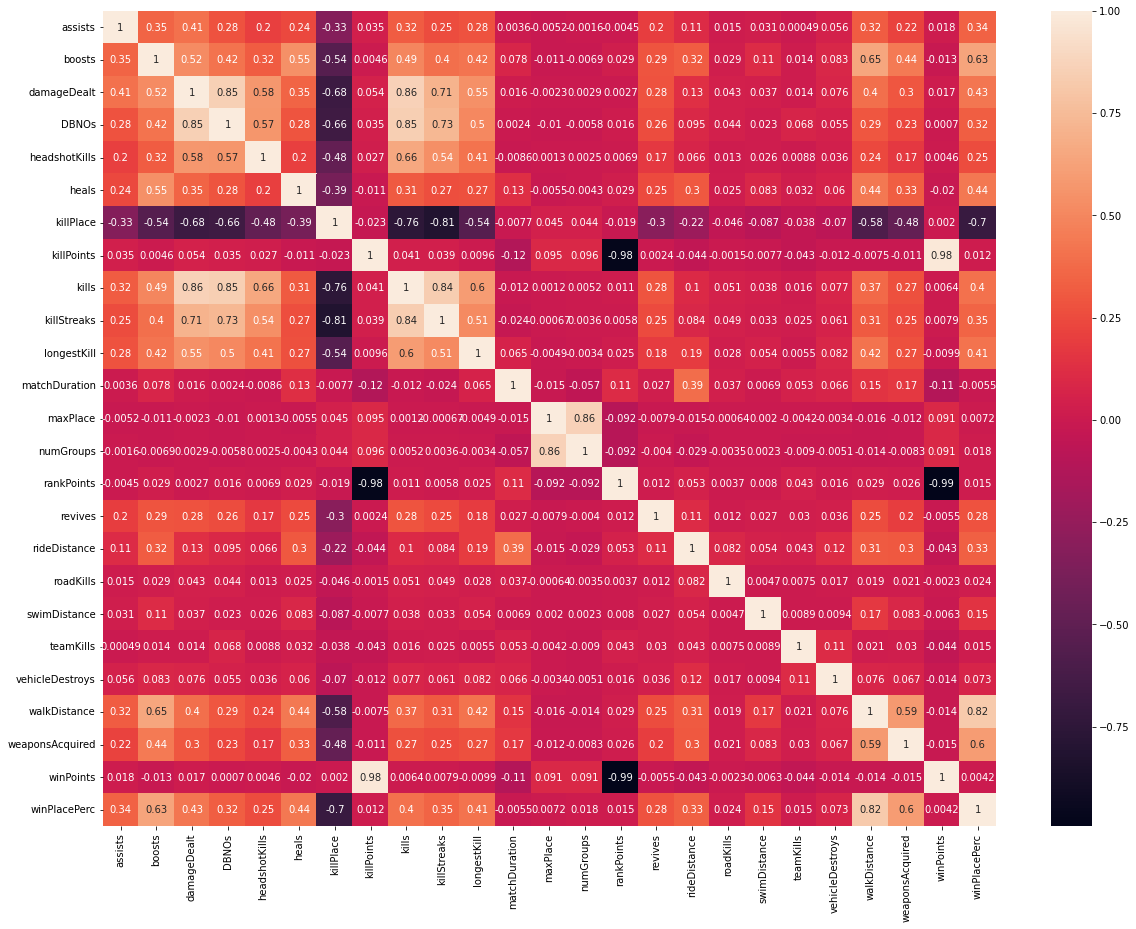

In [ ]:
# drop할 데이터들 추리기(결측치, 상관없는 컬럼, 다중공선성 컬럼)
#종속변수인 winPlacePerc가 Nan값인 row를 지워줍니다. #어케 하더라...
# train[train.isnull().any(axis=1)


plt.figure(figsize=(20,15))
sns.heatmap(train3.corr(), annot=True)

In [ ]:
#a.applymap(int)
train.winPlacePerc.describe().astype(np.float16)


count         inf
mean     0.472900
std      0.307373
min      0.000000
25%      0.199951
50%      0.458252
75%      0.740723
max      1.000000
Name: winPlacePerc, dtype: float16

In [ ]:
# winPlacePerc를 1,2,3,4의 4개의 구간으로 나눔, 기준은 4분위값 이용. 25% 0.199951, 50% 0.458252, 75% 0.740723, max 1.000000
#4개의 구간으로 잘라, winClass 라는 새로운 열 생성

train['winClass'] = pd.cut(train['winPlacePerc'], 4)

#0: 'Child', 1: 'Young', 2: 'Middle', 3: 'Prime', 4: 'Old'`

train.loc[ train['winClass'] <= 0.19, 'winClass'] = 0
train.loc[(train['winClass'] > 0.19) & (train['winClass'] <= 0.45), 'winClass'] = 1
train.loc[(train['winClass'] > 0.45) & (train['winClass'] <= 0.74), 'winClass'] = 2
train.loc[ train['winClass'] > 0.74, 'winClass'] = 3

# map 함수 사용
# genders = {"male": 0, "female": 1}
# titanic['sex'] = titanic['sex'].map(genders)
# titanic.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,winClass
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0.0000,0,0.00,0,0,244.80,1,1466,3.0,"(0.25, 0.5]"
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0.0045,0,11.04,0,0,1434.00,5,0,3.0,"(0.5, 0.75]"
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0.0000,0,0.00,0,0,161.80,2,0,3.0,"(0.75, 1.0]"
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0.0000,0,0.00,0,0,202.70,3,0,0.0,"(-0.001, 0.25]"
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0.0000,0,0.00,0,0,49.75,2,0,0.0,"(-0.001, 0.25]"


In [ ]:
train.winClass.unique()

[(0.25, 0.5], (0.5, 0.75], (0.75, 1.0], (-0.001, 0.25], NaN]
Categories (4, interval[float64, right]): [(-0.001, 0.25] < (0.25, 0.5] < (0.5, 0.75] < (0.75, 1.0]]

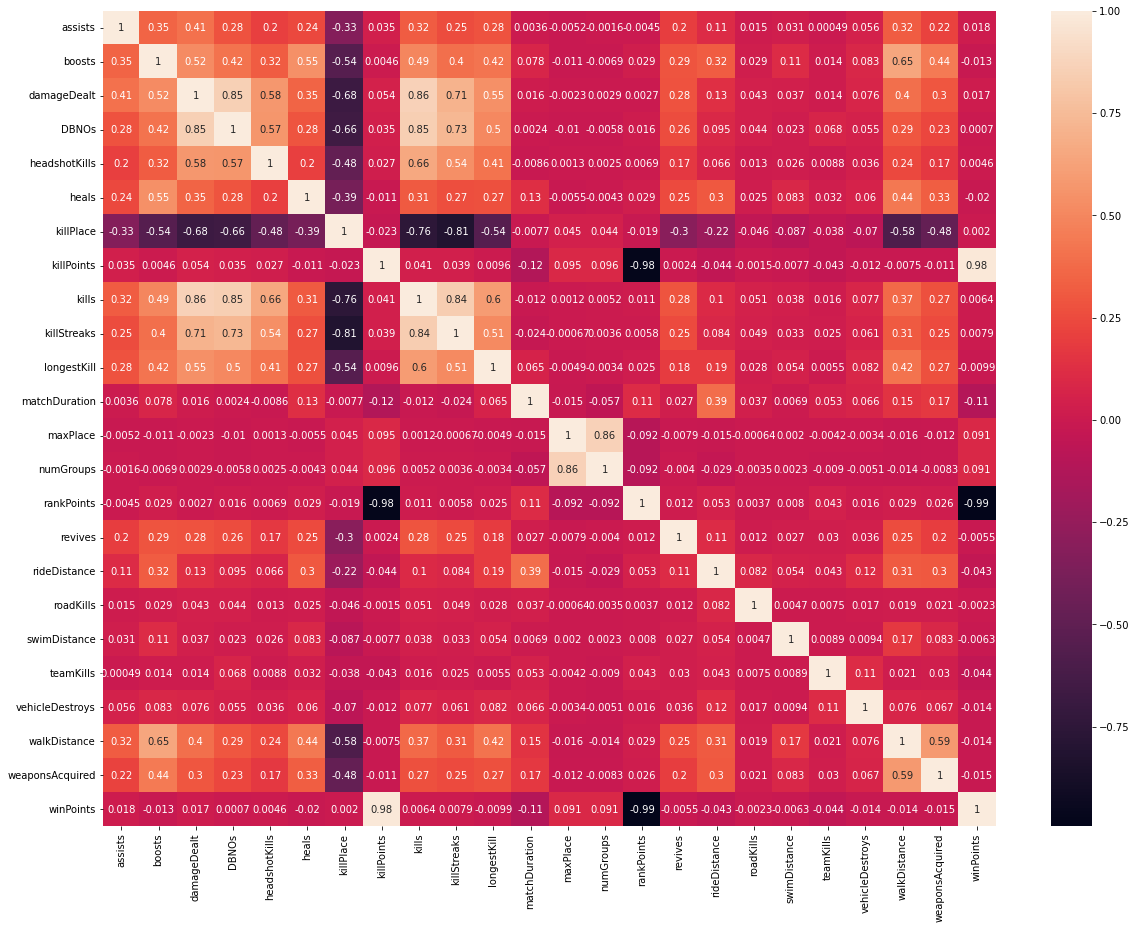

In [ ]:
# 다중공선성 확인을 위한 feature 히트맵

plt.figure(figsize=(20,15))
sns.heatmap(train3.drop(columns=["winPlacePerc"]).corr(), annot=True)


In [ ]:
# walkDistance? -> 많이 돌아다닐수록 승률이 높다? X(오래 살아남았기때문에 이동거리가 높은것, 생존시간과 비례하는 것이므로 인과관계로 해석x. matchDuration, walkDistance, winPlacePerc을 같이 비교해보면 좋을듯. 높은 이동시간과 아이템 파밍은 관련이 있을지도.)
## 히트멥에서 walkDistance를 보면, weaponsAcquired 0.54, boosts 0.64 로 양의 상관관계를 보인다. killPlace -0.59로 음의 상관관계를 보인다. -> 
# boosts -> 경기 시간이 지속될수록 자기장으로 활동 구역이 좁혀지므로 후반에 부스터를 많이 사용하는 유저가 실력이 좋은 유저라는 가설
# weaponsAcquired 승리한 사람들의 평균 무기 개수 확인해보기 
# longestKill 멀리서 킬을 낼 수록 적과 대치할 가능성이 적어지고 피해를 입을 확률도 적을듯
# killStreaks 교전상황에서 킬을 내고 살아남을 수 있는 능력
print("양의 상관관계")
print(train3.corr().sort_values('winPlacePerc', ascending=False)['winPlacePerc'].head(10))


# killPlace와 승률이 음의 상관관계를 보인다. 승률이 높을수록 매치에서 킬 순위가 낮다는 것 => 교전이 적었다. 적들과 대치를 적게 했다 => 몸을 사리는 플레이가 유리하다
print("\n음의 상관관계")
print(train3.corr().sort_values('winPlacePerc', ascending=False)['winPlacePerc'].tail(10))


양의 상관관계
winPlacePerc       1.000000
walkDistance       0.824479
boosts             0.634155
weaponsAcquired    0.600584
heals              0.436548
damageDealt        0.427035
longestKill        0.409168
kills              0.401384
killStreaks        0.350781
assists            0.341578
Name: winPlacePerc, dtype: float64

음의 상관관계
vehicleDestroys    0.072643
roadKills          0.024272
numGroups          0.018279
rankPoints         0.015287
teamKills          0.014733
killPoints         0.011904
maxPlace           0.007157
winPoints          0.004224
matchDuration     -0.005528
killPlace         -0.696270
Name: winPlacePerc, dtype: float64


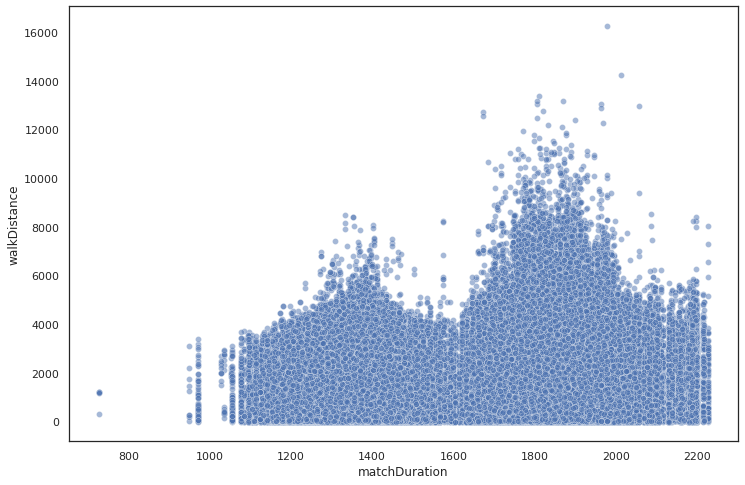

In [ ]:
# walkDistance? -> 많이 돌아다닐수록 승률이 높다? X(오래 살아남았기때문에 이동거리가 높은것, 생존시간과 비례하는 것이므로 인과관계로 해석x. matchDuration, walkDistance, winPlacePerc을 같이 비교해보면 좋을듯. 높은 이동시간과 아이템 파밍은 관련이 있을지도.)
plt.figure(figsize=(12,8))

sns.set_theme(style="white")
sns.scatterplot(x= 'matchDuration', y="walkDistance", alpha=.5, palette="muted", data=train3)

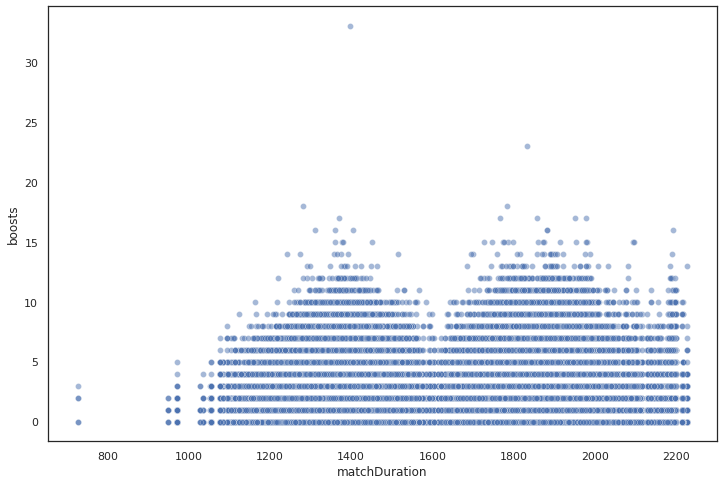

In [34]:
# Duration과 boosts의 연관성.
plt.figure(figsize=(12,8))

sns.set_theme(style="white")
sns.scatterplot(x= 'matchDuration', y="boosts", alpha=.5, palette="muted", data=train3)

In [ ]:
# 1인칭으로 보기.
top10 = train_fpp[train_fpp["winPlacePerc"]>0.9]
top10

print("양의 상관관계", top10.corr().sort_values('winPlacePerc', ascending=False)['winPlacePerc'].head(10))
print("\n음의 상관관계", top10.corr().sort_values('winPlacePerc', ascending=False)['winPlacePerc'].tail(10))

top10.corr()

양의 상관관계 assists         NaN
boosts          NaN
damageDealt     NaN
DBNOs           NaN
headshotKills   NaN
heals           NaN
killPlace       NaN
killPoints      NaN
kills           NaN
killStreaks     NaN
Name: winPlacePerc, dtype: float64

음의 상관관계 revives           NaN
rideDistance      NaN
roadKills         NaN
swimDistance      NaN
teamKills         NaN
vehicleDestroys   NaN
walkDistance      NaN
weaponsAcquired   NaN
winPoints         NaN
winPlacePerc      NaN
Name: winPlacePerc, dtype: float64


,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
assists,1.000000,0.293190,0.365345,0.285060,0.164204,0.203784,-0.272476,0.043877,0.268899,0.214423,0.240542,-0.001343,-0.169280,-0.168919,-0.017452,0.184329,0.080123,0.009052,0.015503,-0.004076,0.049996,0.270105,0.146718,0.023943,NaN
boosts,0.293190,1.000000,0.515078,0.344269,0.327853,0.501822,-0.529003,0.006445,0.497377,0.375023,0.391410,0.082714,-0.030361,-0.030640,0.027489,0.220622,0.267731,0.031893,0.093605,0.001035,0.068555,0.589384,0.347079,-0.014354,NaN
damageDealt,0.365345,0.515078,1.000000,0.737897,0.593650,0.316956,-0.713353,0.055470,0.880190,0.693720,0.546383,0.014662,-0.035501,-0.035320,0.000394,0.242403,0.091669,0.045030,0.021643,-0.000454,0.068896,0.351741,0.220635,0.014940,NaN
DBNOs,0.285060,0.344269,0.737897,1.000000,0.456758,0.248486,-0.577131,0.047971,0.714487,0.640714,0.434849,-0.007737,-0.305078,-0.304664,-0.004655,0.289272,0.068874,0.032136,0.005856,0.058483,0.051457,0.249636,0.144254,0.010805,NaN
headshotKills,0.164204,0.327853,0.593650,0.456758,1.000000,0.180694,-0.508637,0.025069,0.659481,0.502172,0.428500,-0.008106,0.021377,0.021339,0.008706,0.138000,0.044708,0.012429,0.018793,-0.000382,0.032399,0.221587,0.136419,0.000904,NaN
heals,0.203784,0.501822,0.316956,0.248486,0.180694,1.000000,-0.337669,-0.005141,0.282977,0.234692,0.229387,0.133440,-0.084501,-0.085033,0.022139,0.211493,0.252037,0.022914,0.065000,0.026067,0.049673,0.365966,0.234846,-0.016686,NaN
killPlace,-0.272476,-0.529003,-0.713353,-0.577131,-0.508637,-0.337669,1.000000,-0.027934,-0.795445,-0.843483,-0.570622,-0.005623,0.015884,0.016956,-0.016856,-0.245697,-0.148724,-0.050433,-0.065710,-0.016720,-0.058553,-0.495027,-0.323934,0.003295,NaN
killPoints,0.043877,0.006445,0.055470,0.047971,0.025069,-0.005141,-0.027934,1.000000,0.041787,0.040182,0.012441,-0.103962,-0.047530,-0.044721,-0.976354,0.013263,-0.036936,-0.000989,-0.007535,-0.040715,-0.010484,0.000067,-0.009955,0.983739,NaN
kills,0.268899,0.497377,0.880190,0.714487,0.659481,0.282977,-0.795445,0.041787,1.000000,0.802326,0.594278,-0.014698,0.004916,0.005160,0.010453,0.241339,0.066671,0.051273,0.025373,0.002942,0.068360,0.333395,0.208148,0.004087,NaN
killStreaks,0.214423,0.375023,0.693720,0.640714,0.502172,0.234692,-0.843483,0.040182,0.802326,1.000000,0.502462,-0.030611,-0.041558,-0.041389,0.003636,0.225811,0.044478,0.047921,0.018290,0.015595,0.052499,0.258567,0.170041,0.006283,NaN


In [ ]:
plt.figure(figsize=(12,8))

sns.set_theme(style="white")
sns.barplot(x= '', hue='matchType', y="winPlacePerc", alpha=.5, palette="muted", data=train_tpp)

KeyboardInterrupt: ignored

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fdfa45908c0> (for post_execute):


KeyboardInterrupt: ignored

<Figure size 864x576 with 0 Axes>

In [ ]:
train_corr = train3.corr()
train_corr_sort = train_corr.sort_values('winPlacePerc', ascending=False)
train_corr_sort['winPlacePerc'].head(10)

winPlacePerc       1.000000
walkDistance       0.810888
boosts             0.634234
weaponsAcquired    0.583806
damageDealt        0.440507
heals              0.427857
kills              0.419916
longestKill        0.410154
killStreaks        0.377566
rideDistance       0.342915
Name: winPlacePerc, dtype: float64

In [ ]:
train_corr_sort['winPlacePerc'].tail(10)


NameError: ignored

In [ ]:
cols =['walkDistance', 'boosts', 'weaponsAcquired', 'damageDealt', 'heals', 'kills', 'longestKill', 'killStreaks', 'rideDistance', 'assists']
sns.pairplot(train3[cols])
plt.show()

In [ ]:
## On your Own
data.column.value_counts()
sns.countplot()
sns.histplot()
...

이런 식으로 여러가지 그래프를 그려가며, 데이터에 대한 인사이트를 얻습니다!

### 3. 전처리

#### 결측치 처리

In [ ]:
# 결측치가 있는 column


In [ ]:
# 중복정보가 있는 column 제거하기 위해 상관계수를 확인해봅니다.
correlated_features = 

#### 다중공선성 처리

In [ ]:
# 상관계수가 threshold(e.g. 0.8)를 넘기는 feature들을 제거합니다.
threshold = 

#### Encoding Categorical Features

In [ ]:
# dtype이 object인 변수들 처리.


#### feature extraction

- 차원의 저주를 해결하거나, 데이터의 feature 조합을 이용하는 새로운 feature를 생성할 때, PCA를 사용합니다.

- 분석에 사용할 feature를 선택하는 과정도 포함합니다.

In [ ]:
# PCA 적용
from sklearn.decomposition import PCA

if feature_reducing:
    pca = PCA(n_components=0.9) # PCA(n_components=6)
    pca_data = pca.fit_transform(X)

### 4. 학습 데이터 분할

In [ ]:
# 첫번째 테스트용으로 사용하고, 실제 학습시에는 K-Fold CV를 사용합니다.
# train : test = 8 : 2
from sklearn.model_selection import train_test_split

X = 
y =

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

### 5. 학습 및 평가

In [ ]:
# 간단하게 LightGBM 테스트
# 적당한 hyper-parameter 조합을 두었습니다. (항상 best는 아닙니다. 예시입니다.)

param_grid = {
    "max_bin" : 20,
    "learning_rate" : 0.0025,
    "objective" : "regression",
    "boosting_type" : "gbdt",
    "metric" : "mae",
    "sub_feature" : 0.345,
    "bagging_fraction" : 0.85,
    "bagging_freq" : 40,
    "num_leaves" : 512,
    "min_data" : 500,
    "min_hessian" : 0.05,
    "verbose" : 2,
    "feature_fraction_seed" : 2,
    "bagging_seed" : 3
}

model = LGBMRegressor(**param_grid)

In [ ]:
print("\nFitting LightGBM...")
model.fit(X_train, y_train)

In [ ]:
# metric은 그때마다 맞게 바꿔줘야 합니다.
evaluation_metric = 

In [ ]:
print("Prediction")
pred_train = model.predict(x_train)
pred_test = model.predict(x_test)


train_score = evaluation_metric(y_train, pred_train)
test_score = evaluation_metric(y_test, pred_test)

print("Train Score : %.4f" % train_score)
print("Test Score : %.4f" % test_score)

### 6. Hyper-parameter Tuning

> GridSearchCV

** LightGBM의 hyperparameter **

[Official Documentation] https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html 

[Blog 1] https://smecsm.tistory.com/133

[Blog 2] https://towardsdatascience.com/kagglers-guide-to-lightgbm-hyperparameter-tuning-with-optuna-in-2021-ed048d9838b5

[Blog 3] https://nurilee.com/2020/04/03/lightgbm-definition-parameter-tuning/

In [ ]:
# GridSearchCV를 이용하여 가장 좋은 성능을 가지는 모델을 찾아봅시다. (이것은 첫번째엔 선택입니다.)
# Lightgbm은 hyper-parameter의 영향을 많이 받기 때문에, 저는 보통 맨처음에 한번 정도는 가볍게 GCV를 해봅니다.
# 성능 향상이 별로 없다면, lightgbm으로 돌린 대략적인 성능이 이 정도라고 생각하면 됩니다.
# 만약 성능 향상이 크다면, 지금 데이터는 hyper-parameter tuning을 빡빡하게 하면 성능 향상이 많이 이끌어 낼 수 있습니다.

from sklearn.model_selection import GridSearchCV

param_grid = {
    "max_depth" : [8, 16, None],
    "n_estimators" : [100, 300, 500],
    "max_bin" : [20],
    "learning_rate" : [0.001, 0.0025, 0.003],
    "objective" : ["regression"],
    "boosting_type" : ["gbdt"],
    "metric" : ["mae"],
    "sub_feature" : [0.345],
    "bagging_fraction" : [0.7, 0.75, 0.85],
    "bagging_freq" : [40],
    "num_leaves" : [256, 512],
    "min_data" : [500],
    "verbose" : [-1], # 필수
    "min_hessian" : [0.05],
    "feature_fraction_seed" : [2],
    "bagging_seed" : [3]
}


gcv = GridSearchCV(estimator=model, param_grid=param_grid, cv=5,
                  n_jobs=-1, verbose=1)

gcv.fit(X_train, y_train)
print("Best Estimator : ", gcv.best_estimator_)

In [ ]:
print("Prediction with Best Estimator")
gcv_pred_train = gcv.predict(X_train)
gcv_pred_test = gcv.predict(x_test)

gcv_train_score = evaluation_metric(y_train, gcv_pred_train)
gcv_test_score = evaluation_metric(y_test, gcv_pred_test)

print("Train MAE Score : %.4f" % gcv_train_score)
print("Test MAE Score : %.4f" % gcv_test_score)

In [ ]:
print("Performance Gain") # 이걸로 성능 향상 확인.
print("in train : ", (train_score - gcv_train_score))
print("in test : ", (test_score - gcv_test_score))

> optuna를 사용해봅시다 !

In [ ]:
def optimizer(trial, X, y, K):
    # 조절할 hyper-parameter 조합을 적어줍니다.
    n_estimators = 
    max_depth = 
    max_features = 
    
    
    # 원하는 모델을 지정합니다, optuna는 시간이 오래걸리기 때문에 저는 보통 RF로 일단 테스트를 해본 뒤에 LGBM을 사용합니다.
    model = RandomForestRegressor(n_estimators=n_estimators,
                                 max_depth=max_depth,
                                 max_features=max_features)
    
    
    # K-Fold Cross validation을 구현합니다.
    folds = KFold(n_splits=K)
    losses = []
    
    for train_idx, val_idx in folds.split(X, y):
        X_train = X.iloc[train_idx, :]
        y_train = y.iloc[train_idx]
        
        X_val = X.iloc[val_idx, :]
        y_val = y.iloc[val_idx]
        
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        loss = mean_absolute_error(y_val, preds)
        losses.append(loss)
    
    
    # K-Fold의 평균 loss값을 돌려줍니다.
    return np.mean(losses)

In [ ]:
K = # Kfold 수
opt_func = partial(optimizer, X=X_train, y=y_train, K)

study = optuna.create_study(direction="minimize") # 최소/최대 어느 방향의 최적값을 구할 건지.
study.optimize(opt_func, n_trials=5)

In [ ]:
# optuna가 시도했던 모든 실험 관련 데이터
study.trials_dataframe()

In [ ]:
print("Best Score: %.4f" % study.best_value) # best score 출력
print("Best params: ", study.best_trial.params) # best score일 때의 하이퍼파라미터들

In [ ]:
# 실험 기록 시각화
optuna.visualization.plot_optimization_history(study)

In [ ]:
# hyper-parameter들의 중요도
optuna.visualization.plot_param_importances(study)

### 7. 테스트 및 제출 파일 생성

In [ ]:
model = RandomForestRegressor(n_estimators=study.best_trial.params["n_estimators"],
                                 max_depth=study.best_trial.params["max_depth"],
                                 max_features=study.best_trial.params["max_features"])

model.fit(X_train, y_train)
preds = model.predict(X_test)
preds

In [ ]:
X_test # 원본 데이터랑 id가 맞는지 확인 해보기!

In [ ]:
submission = pd.DataFrame() # submission을 생성합니다.
submission

In [ ]:
submission.reset_index(drop=True).to_csv("submission.csv", index=False)